In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd ..

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo


In [3]:
import sys
import os

import numpy as np
import pandas as pd
import random
import tensorflow as tf

from tensorflow import keras
from keras import layers
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

from scripts.CustomCallbacks import CustomLogger
import scripts.utils as utils
import scripts.Slopes as Slopes

from tqdm import tqdm
import json

from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import operator
import statsmodels.api as sm
import pickle

utils.reset_seeds(0)
pd.set_option('display.max_columns', 50)

In [4]:
regioon = ['a', 'b', 'c', 'd', 'e']
naabrid = [['b'], ['a','c'], ['b','d'], ['c','e'], ['d']]
kaugemad = [['c'], ['d'], ['a','e'], ['b'], ['c']]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

with open('ols_model.pkl', 'rb') as f:
    final_model = pickle.load(f)
with open('points_model.pkl', 'rb') as f:
    points_result = pickle.load(f)
with open('bpoints_model.pkl', 'rb') as f:
    bpoints_result = pickle.load(f)

with open('general_scaler.pkl', 'rb') as f:
    general_scaler = pickle.load(f)
with open('points_scaler.pkl', 'rb') as f:
    points_scaler = pickle.load(f)
with open('bpoint_scaler.pkl', 'rb') as f:
    bpoint_scaler = pickle.load(f)

def process_break_points(file_path, regions):
    with open(file_path, 'rb') as f:
        data = np.load(f)
    # print(data)
    return np.histogram(data[:, 0], bins=regions)[0]

def process_rmse(file_path, regions):
    with open(file_path, 'rb') as f:
        data = np.load(f)

    # splitime andmed vastavalt regionitele jätame välja piirkonnad mis on väiksem ja suurem kui andmete piirid
    r_all = np.split(data, np.searchsorted(data[:, 0], v=regions))[1:-1]
    
    # absoluutsed vahed joonte 2. ja 3. vahel (keskmine piirkonnas)
    absoluut_vahed = [np.mean(r[:, 2] - r[:, 3]) for r in r_all]

    # 3. joone keskmine igas piirkonnas
    r3_mean = [np.mean(r[:, 3]) for r in r_all]
    # 2. joone keskmine igas piirkonnas
    r2_mean =  [np.mean(r[:, 2]) for r in r_all]

    # suhtelised vahed joonte 2. ja 3. vahel (keskmine piirkonnas)
    suhtelised_vahed = [absoluut / r_m for absoluut, r_m in zip(absoluut_vahed, r3_mean)]

    return absoluut_vahed, suhtelised_vahed, (r2_mean, r3_mean)
def laisk_nll(y_true, ypredmean, ypredlogvar):
    # tf.reduce_mean(y_pred_var + tf.math.square(y_true - y_pred_mean) / tf.math.exp(y_pred_var))
    return np.mean(ypredmean + (y_true -ypredmean)**2 / np.exp(ypredlogvar))

In [5]:
# const	-0.0912
# neighbour_raw_mean2	0.5223
# distant_raw_mean2	0.6167
# mse_treeningul	-0.2948
# points_combo	0.9997
# bpoints_combo	0.8915

In [6]:
baasdir = "const_func_uneven_data"
# done train_size = params['train_size']
# done random_seed = params['random_seed']
# done multiplier = params['multiplier']
# done region = ord(params['region'])-65
# fn = params['fn']
# noise_fn=params["noise_fn"]
# reverse_noise = params["reverse_noise"]

In [7]:
df_columns = ['train_size', 'random_seed', 'multiplier', 'region',
              *[f'bpoints_in_{chr(a)}' for a in range(97, 97+5)],
              #*[f'ext_bpoints_in_{chr(a)}' for a in range(97, 97+5)],
              #*[f'abs_diff_in_{chr(a)}' for a in range(97, 97+5)],
              *[f'rel_diff_in_{chr(a)}' for a in range(97, 97+5)],
              *[f'raw_mean2_in_{chr(a)}' for a in range(97, 97+5)],
              #*[f'raw_mean3_in_{chr(a)}' for a in range(97, 97+5)],
              'mse_treeningul',]

In [8]:
nimed = ['my_bpoints', 'neighbour_bpoints', 'distant_bpoints',
       'my_raw_mean2', 'neighbour_raw_mean2', 'distant_raw_mean2',
       'my_points', 'neighbour_points', 'distant_points', 'my_points_m1',
       'my_points_log', 'my_points_logm1', 'neighbour_points_m1',
       'neighbour_points_log', 'neighbour_points_logm1',
       'distant_points_m1', 'distant_points_log', 'distant_points_logm1',
       'mse_treeningul']

In [9]:
def kombineeri_tunnus_mudelist_ja_dfist(mudel, df):
    series = np.zeros(shape=df.shape[0])
    for param in mudel.params.keys():
        if param!="const":
            series += df[param] * mudel.params[param] 
        else:
            series += np.ones(shape=df.shape[0]) * mudel.params["const"]
    return series

In [10]:
uus_df_temp = []
uus_df_cols = ['train_size', 'seed', 'multiplier','region', 'vana_nll', 'uus_nll']
for dirpath, dirs_in_dir, files in os.walk(baasdir):
    if "models" in dirpath:
        continue
    if "plots" in dirpath:
        continue
    if len(files) != 0:
        # print(dirpath)
        head, multiplier_region = os.path.split(dirpath)
        head, seed = os.path.split(head)
        head, train_size = os.path.split(head)
        multiplier, region = float(multiplier_region[:-1]), multiplier_region[-1]
        seed, train_size = int(seed), int(train_size)

        if "sin" in dirpath:
            fn = lambda x:x*np.sin(x)
        else:
            fn = lambda x:0*x
        noise_fn = lambda X: 0.3 * np.random.randn(len(X)) + 0.3 * X * np.random.randn(len(X))
        if "reverse" in dirpath:
            reverse_noise=True
        else:
            reverse_noise=False
        
        bpoints = process_break_points(os.path.join(dirpath, "bpoints.npy"), np.arange(0, 12, 2))
        abs_diff, rel_diff, (raw_mean2, raw_mean3) = process_rmse(os.path.join(dirpath, "rmses.npy"), np.arange(0, 12, 2))
        with open(os.path.join(dirpath, "mses.json"), 'r', encoding="cp1252") as f:
            mses = json.load(f)
            mse_treeningul = mses["mse_treeningul"]
        
       
        with open(os.path.join(dirpath, "y_pred.npy"), 'rb') as f:
            y_preds = np.load(f)


        andmestik = pd.DataFrame(data=[[train_size, seed, multiplier,region, *bpoints, *rel_diff, *raw_mean2, mse_treeningul]], columns=df_columns)

        Xid, yid = [], []
        for r, n, k in regioonide_combod:
            
            X, y = utils.transform_no_scaling(andmestik, r, n, k)
            Xid.append(X)
            yid.append(y) 

        suurX = pd.concat(Xid, ignore_index=True)
        suury = pd.concat(yid, ignore_index=True)
        # print("train_size, seed, multiplier,region")
        # print(train_size, seed, multiplier,region)
        # display(suurX.head())

        suurX[points_scaler.feature_names_in_] = points_scaler.transform(suurX[points_scaler.feature_names_in_])
        suurX["points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(points_result, suurX)
        suurX[bpoint_scaler.feature_names_in_] = bpoint_scaler.transform(suurX[bpoint_scaler.feature_names_in_])
        suurX["bpoints_combo"] = kombineeri_tunnus_mudelist_ja_dfist(bpoints_result, suurX)

        
        uuritavad_col = general_scaler.feature_names_in_
        suurX = suurX[uuritavad_col]
        suurX = general_scaler.transform(suurX)
        suurX = pd.DataFrame(suurX, columns=uuritavad_col)
        suurX["const"] = 1

        y_pred_mean = y_preds[:,0]
        y_pred_logvar = y_preds[:,1]
        a = np.exp(y_pred_logvar)
        y_pred_sd = np.sqrt(np.exp(y_pred_logvar))
        correctors = final_model.predict(suurX)
        b = correctors.repeat(y_preds.shape[0]/5)

        x = a / (b+1)  # ühik : var
        x_logvar = np.log(x)
        
        x_sd = np.sqrt(np.exp(x))


        utils.reset_seeds(seed)
        
        X = utils.create_x_train(train_size=train_size, different_place=ord(region)-65, different_multiplier=multiplier)
        X = np.linspace(0,10,1000000)
        if reverse_noise:
            y_true = fn(X) + noise_fn(X[::-1])
        else:
            y_true = fn(X) + noise_fn(X)
        vana = laisk_nll(y_true, y_pred_mean, y_pred_logvar)
        uus = laisk_nll(y_true, y_pred_mean, x_logvar)
        uus_df_temp.append([train_size, seed, multiplier,region, vana, uus])

# suurX.head()
df = pd.DataFrame(data=uus_df_temp, columns=uus_df_cols)
df.to_csv("andmed/test_improvements.csv", index=False)

,train_size,seed,multiplier,region,vana_nll,uus_nll
0,10,0,0.25,A,5.524463,4.123177
1,10,0,0.25,B,5.677048,3.897225
2,10,0,0.25,C,7.781107,4.781684
3,10,0,0.50,A,6.910061,4.399412
4,10,0,0.50,B,8.671155,5.057796
5,10,0,0.50,C,11.702075,6.165707
6,10,0,1.00,A,88.683474,36.877365
7,10,0,1.00,B,54.365899,22.933896
8,10,0,2.00,A,2.680606,1.437126
9,10,0,2.00,B,2.631596,1.544498


## Improvements

In [4]:
dfs = pd.read_csv("andmed/parandatud_improvement/sin_improvement.csv")
dfs["type"] = "sin"
dfsr = pd.read_csv("andmed/parandatud_improvement/sin_reverse_improvement.csv")
dfsr["type"] = "sin_reverse"
dfc = pd.read_csv("andmed/parandatud_improvement/const_improvement.csv")
dfc["type"] = "const"
dfcr = pd.read_csv("andmed/parandatud_improvement/reverse_improvement.csv")
dfcr["type"] = "const_reverse"
df = pd.concat([dfs, dfsr, dfc, dfcr], ignore_index=True)

In [5]:
df["improvement"] = df["vana_nll"] -df["uus_nll"]
# df = df[df["improvement"] < 10**7]
# df = df.groupby(['region', 'multiplier', 'train_size', 'type']).mean().reset_index()

In [6]:
df.head()

,train_size,seed,multiplier,region,vana_nll,uus_nll,type,improvement
0,80,34,0.50,A,2.882363,4.716655,sin,-1.834292
1,80,34,0.25,A,2.738229,4.088671,sin,-1.350442
2,80,34,0.25,B,2.487368,4.112738,sin,-1.625370
3,80,34,4.00,E,2.744050,5.106073,sin,-2.362023
4,80,34,4.00,A,2.726883,3.717213,sin,-0.990330


In [7]:
df[df["vana_nll"]<10]

,train_size,seed,multiplier,region,vana_nll,uus_nll,type,improvement
0,80,34,0.50,A,2.882363,4.716655,sin,-1.834292
1,80,34,0.25,A,2.738229,4.088671,sin,-1.350442
2,80,34,0.25,B,2.487368,4.112738,sin,-1.625370
3,80,34,4.00,E,2.744050,5.106073,sin,-2.362023
4,80,34,4.00,A,2.726883,3.717213,sin,-0.990330
...,...,...,...,...,...,...,...,...
94318,10,18,4.00,C,1.554721,2.323178,const_reverse,-0.768457
94319,10,18,4.00,D,8.455135,12.662819,const_reverse,-4.207683
94322,10,18,2.00,A,2.462208,4.264431,const_reverse,-1.802223
94323,10,18,2.00,B,1.966644,3.371689,const_reverse,-1.405045


In [15]:
df.shape

(94335, 8)

In [8]:
df[(df["improvement"] > 0)].shape

(186, 8)

In [9]:
df[(df["improvement"] > 0)]

,train_size,seed,multiplier,region,vana_nll,uus_nll,type,improvement
5106,70,24,4.00,B,1.011468e+01,9.940967e+00,sin,1.737117e-01
13856,40,24,4.00,B,2.538389e+01,2.534947e+01,sin,3.442268e-02
21365,90,24,2.00,C,3.620628e+01,3.195833e+01,sin,4.247950e+00
23890,80,27,2.00,C,7.564650e+00,7.401918e+00,sin_reverse,1.627320e-01
26364,175,24,0.50,B,4.037092e+03,3.652836e+03,sin_reverse,3.842568e+02
...,...,...,...,...,...,...,...,...
94057,10,25,0.50,B,3.509236e+01,2.894069e+01,const_reverse,6.151670e+00
94059,10,25,0.50,C,6.871050e+07,6.322112e+07,const_reverse,5.489379e+06
94087,10,9,0.25,B,1.217027e+03,1.085986e+03,const_reverse,1.310403e+02
94206,10,42,1.00,B,1.234468e+02,1.184638e+02,const_reverse,4.982965e+00


In [15]:
df[(df["improvement"] > 0)&(df["vana_nll"] > 10)].shape

(171, 8)

In [1]:
df[(df["improvement"] > 0)&(df["vana_nll"] < 10**3)].vana_nll.plot(kind="hist")

NameError: name 'df' is not defined

In [11]:
multi_kaudu = df[df["type"]=="const_reverse"].groupby(['multiplier']).mean().reset_index()
multi_kaudu

C:\Users\troosma\AppData\Local\Temp\ipykernel_11632\447603749.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  multi_kaudu = df[df["type"]=="const_reverse"].groupby(['multiplier']).mean().reset_index()


,multiplier,train_size,seed,vana_nll,uus_nll,improvement
0,0.25,300.0,24.72093,492.582936,0.858810,491.724126
1,0.50,300.0,24.50000,14663.334036,0.804438,14662.529598
2,1.00,300.0,24.50000,151.158792,0.720320,150.438472
3,2.00,300.0,24.50000,557.024887,0.739703,556.285184
4,4.00,300.0,24.50000,160.637683,0.813904,159.823780


In [39]:
reg_kaudu = df.groupby(['region']).mean().reset_index()
reg_kaudu

,region,multiplier,train_size,seed,vana_nll,uus_nll,improvement
0,A,1.55,300.0,24.500000,182.825338,1.867310,180.958029
1,B,1.55,300.0,24.500000,67.855625,1.843004,66.012621
2,C,1.55,300.0,24.500000,75.748175,1.874529,73.873646
3,D,1.55,300.0,24.500000,73.683456,2.112395,71.571061
4,E,1.55,300.0,24.497959,76.355209,1.998331,74.356877


In [40]:
train_size_kaudu = df.groupby(['train_size']).mean().reset_index()
train_size_kaudu

C:\Users\troosma\AppData\Local\Temp\ipykernel_28572\9094199.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_size_kaudu = df.groupby(['train_size']).mean().reset_index()


,train_size,multiplier,seed,vana_nll,uus_nll,improvement
0,10,1.55,24.492245,959.253969,5.962129,953.291841
1,20,1.55,24.500000,171.315677,2.966779,168.348898
2,30,1.55,24.500000,69.784249,1.920233,67.864016
3,40,1.55,24.500000,45.168841,1.674060,43.494782
4,50,1.55,24.500000,57.777643,1.706313,56.071330
5,60,1.55,24.500000,15.299207,1.835568,13.463639
6,70,1.55,24.500000,449.653464,1.690815,447.962649
7,80,1.55,24.500000,6.536846,1.711783,4.825063
8,90,1.55,24.500000,5.128700,1.708448,3.420252
9,100,1.55,24.500000,7.938818,1.687491,6.251327


<AxesSubplot: xlabel='region', ylabel='multiplier'>

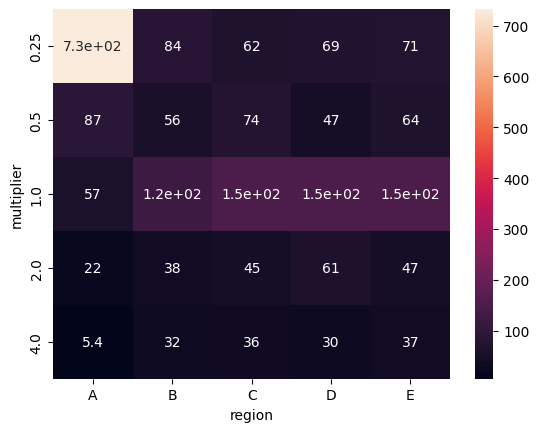

In [52]:
mult_ja_reg = df.groupby(['multiplier', 'region']).mean().reset_index()
mult_ja_reg = mult_ja_reg.pivot_table(index="multiplier", columns="region", values="improvement")
sns.heatmap(data=mult_ja_reg, annot=True)
# mult_ja_reg

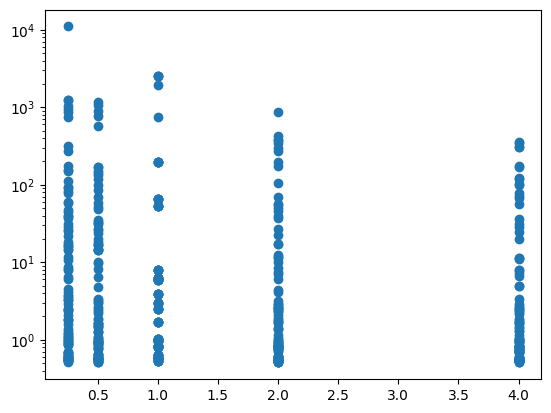

In [36]:
plt.yscale("log")
plt.scatter(df["multiplier"], df["improvement"])

In [25]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
multiplier,475.0,1.550000e+00,1.365256e+00,0.250000,0.500000,1.000000,2.000000,4.000000e+00
train_size,475.0,3.000000e+02,4.769060e+02,10.000000,50.000000,100.000000,250.000000,2.000000e+03
seed,475.0,2.450000e+01,0.000000e+00,24.500000,24.500000,24.500000,24.500000,2.450000e+01
vana_nll,475.0,1.523834e+08,3.321116e+09,1.721340,2.351034,3.554057,18.472259,7.238205e+10
uus_nll,475.0,1.939009e+00,1.475350e+00,0.324701,1.423939,1.684874,1.870401,2.319837e+01
improvement,475.0,1.523833e+08,3.321116e+09,0.509987,0.781709,1.804027,16.634117,7.238205e+10
